In [36]:
# 0. Check if the enviroment is working

import sys
print(sys.executable)

/opt/anaconda3/envs/ie_deeplearning/bin/python


In [60]:
# 1. Setup libraries

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from IPython.display import display, Markdown


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           # Measures the ability of the model to distinguish between classes (higher is better)
    average_precision_score, # Computes the average precision for precision-recall curves (useful for imbalanced data)
    brier_score_loss,        # Measures the mean squared difference between predicted probabilities and actual outcomes (lower is better)
    log_loss,                # Penalizes false classifications with a focus on probability estimates (lower is better)
    confusion_matrix,        # Summarizes true/false positives/negatives for classification predictions
    precision_score,         # Proportion of positive identifications that were actually correct (TP / (TP + FP))
    recall_score,            # Proportion of actual positives that were correctly identified (TP / (TP + FN))
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
)
# Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

# Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from raiwidgets import ResponsibleAIDashboard
    _RAI = True
except Exception:
    _RAI = False

# Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Loading the data

In [38]:
# Path to your CSV (update if needed for your system)

DATA_PATH = "/Users/jvcalventi/Downloads/Influenza_Detection.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(1750)


Shape: (10835, 16)


,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1),A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (Yamagata),B (lineage not determined)
0,1,Afghanistan,Non-sentinel,2024-39,2024-09-23,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Afghanistan,Non-sentinel,2024-40,2024-09-30,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Afghanistan,Non-sentinel,2024-41,2024-10-07,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Afghanistan,Non-sentinel,2024-42,2024-10-14,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Afghanistan,Non-sentinel,2024-43,2024-10-21,0,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,1746,Chile,Non-sentinel,2025-38,2025-09-15,3520,360,3160,NaN,15.0,28.0,NaN,259.0,30.0,0.0,28.0
1746,1747,Chile,Sentinel,2024-39,2024-09-23,369,14,355,0.0,0.0,2.0,NaN,1.0,0.0,0.0,11.0
1747,1748,Chile,Sentinel,2024-40,2024-09-30,390,22,368,0.0,1.0,1.0,NaN,0.0,3.0,0.0,17.0
1748,1749,Chile,Sentinel,2024-41,2024-10-07,389,31,358,0.0,0.0,0.0,NaN,5.0,8.0,0.0,18.0


# Exploartory Data Analysis

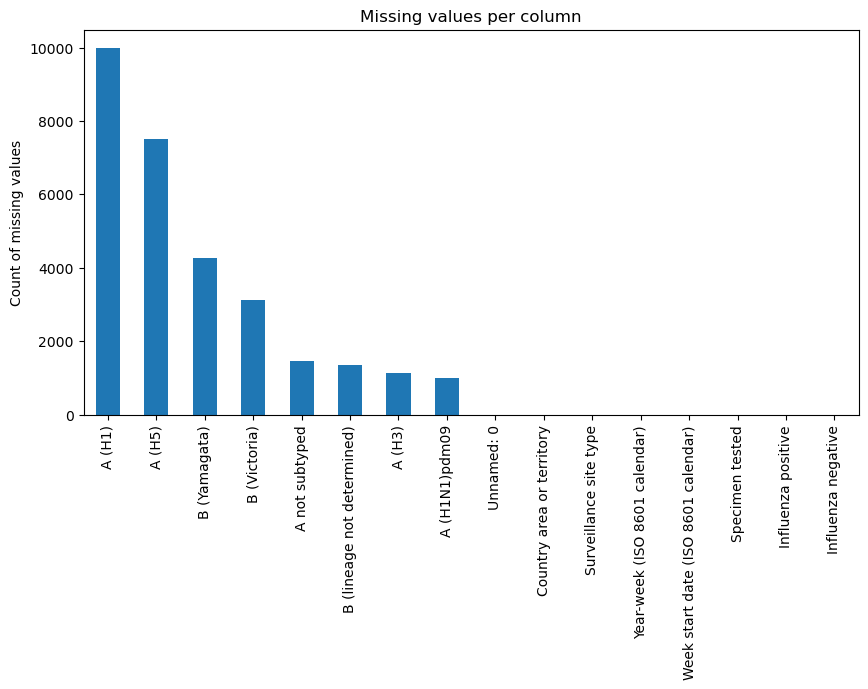

New shape after dropping subtype columns: (10835, 8)


,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative
0,1,Afghanistan,Non-sentinel,2024-39,2024-09-23,0,0,0
1,2,Afghanistan,Non-sentinel,2024-40,2024-09-30,0,0,0
2,3,Afghanistan,Non-sentinel,2024-41,2024-10-07,0,0,0
3,4,Afghanistan,Non-sentinel,2024-42,2024-10-14,0,0,0
4,5,Afghanistan,Non-sentinel,2024-43,2024-10-21,0,0,0


In [39]:
# Visualize missing values


missing = df_raw.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
missing.plot(kind="bar")
plt.title("Missing values per column")
plt.ylabel("Count of missing values")
plt.show()

# Drop subtype columns
subtype_cols = [
    "A (H1)", "A (H1N1)pdm09", "A (H3)", "A (H5)", 
    "A not subtyped", "B (Victoria)", "B (Yamagata)", 
    "B (lineage not determined)"
]

#Defining new clean dataset without N/A values

df_clean = df_raw.drop(columns=subtype_cols)
print("New shape after dropping subtype columns:", df_clean.shape)
df_clean.head()

## Understanding the Categorical Variables

Shape: (10835, 8)

Data types:
Unnamed: 0                              int64
Country area or territory              object
Surveillance site type                 object
Year-week (ISO 8601 calendar)          object
Week start date (ISO 8601 calendar)    object
Specimen tested                         int64
Influenza positive                      int64
Influenza negative                      int64
dtype: object

Unique surveillance site types:
['Non-sentinel' 'Sentinel' 'Not defined']

Unique countries (sample):
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain']

Summary statistics for numerical variables:


,Unnamed: 0,Specimen tested,Influenza positive,Influenza negative
count,10835.000000,10835.000000,10835.00000,10835.000000
mean,5418.000000,1124.433872,150.47688,973.927550
std,3127.939418,6791.933597,1344.63676,5776.234079
min,1.000000,0.000000,0.00000,-10793.000000
25%,2709.500000,14.000000,0.00000,12.000000
50%,5418.000000,59.000000,5.00000,50.000000
75%,8126.500000,200.000000,27.00000,165.000000
max,10835.000000,178401.000000,56036.00000,122365.000000



Distribution of surveillance site types:
Surveillance site type
Sentinel        5828
Non-sentinel    3718
Not defined     1289
Name: count, dtype: int64


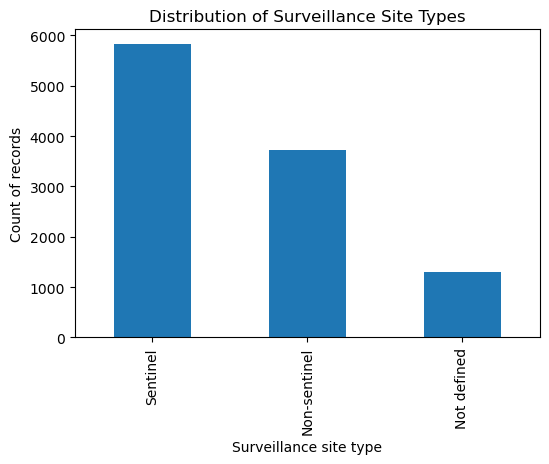

In [41]:
# Basic info on cleaned dataset

print("Shape:", df_clean.shape)
print("\nData types:")
print(df_clean.dtypes)

# Unique values for categorical variables
print("\nUnique surveillance site types:")
print(df_clean["Surveillance site type"].unique())

print("\nUnique countries (sample):")
print(df_clean["Country area or territory"].unique()[:10])  # show first 10 only

# Summary statistics for numerical variables
print("\nSummary statistics for numerical variables:")
display(df_clean.describe())

# Distribution of surveillance site type
site_counts = df_clean["Surveillance site type"].value_counts()
print("\nDistribution of surveillance site types:")
print(site_counts)

# Quick bar plot of site type distribution
site_counts.plot(kind="bar", figsize=(6,4), title="Distribution of Surveillance Site Types")
plt.ylabel("Count of records")
plt.show()


## Understanding the Numerical Variables

Summary statistics:


,Influenza positive,Influenza negative
count,10835.00000,10835.000000
mean,150.47688,973.927550
std,1344.63676,5776.234079
min,0.00000,-10793.000000
25%,0.00000,12.000000
50%,5.00000,50.000000
75%,27.00000,165.000000
max,56036.00000,122365.000000


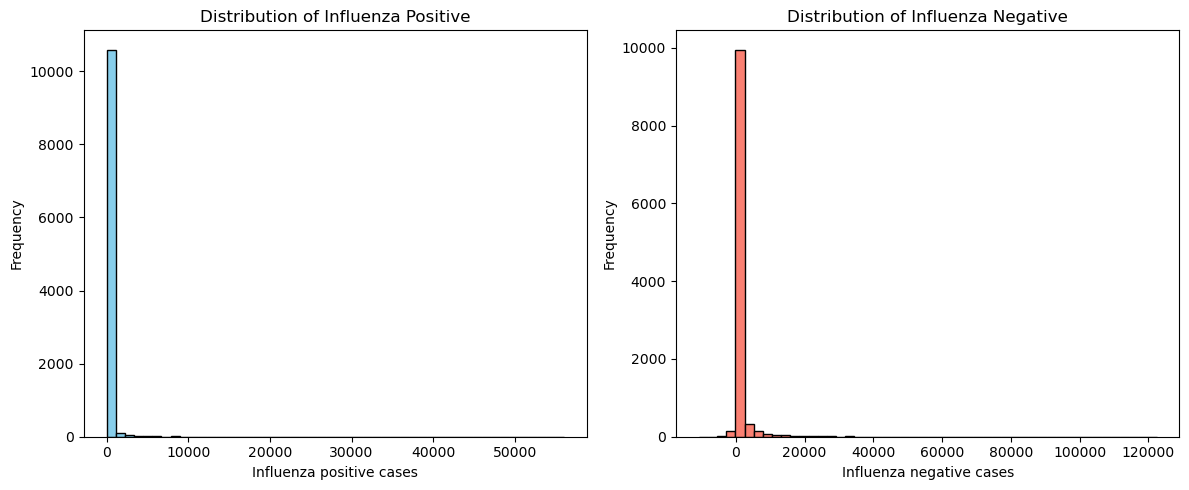

In [42]:
# Summary statistics for influenza positive & negative

print("Summary statistics:")
display(df_clean[["Influenza positive", "Influenza negative"]].describe())

# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_clean["Influenza positive"].plot(kind="hist", bins=50, ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("Distribution of Influenza Positive")
axes[0].set_xlabel("Influenza positive cases")

df_clean["Influenza negative"].plot(kind="hist", bins=50, ax=axes[1], color="salmon", edgecolor="black")
axes[1].set_title("Distribution of Influenza Negative")
axes[1].set_xlabel("Influenza negative cases")

plt.tight_layout()
plt.show()


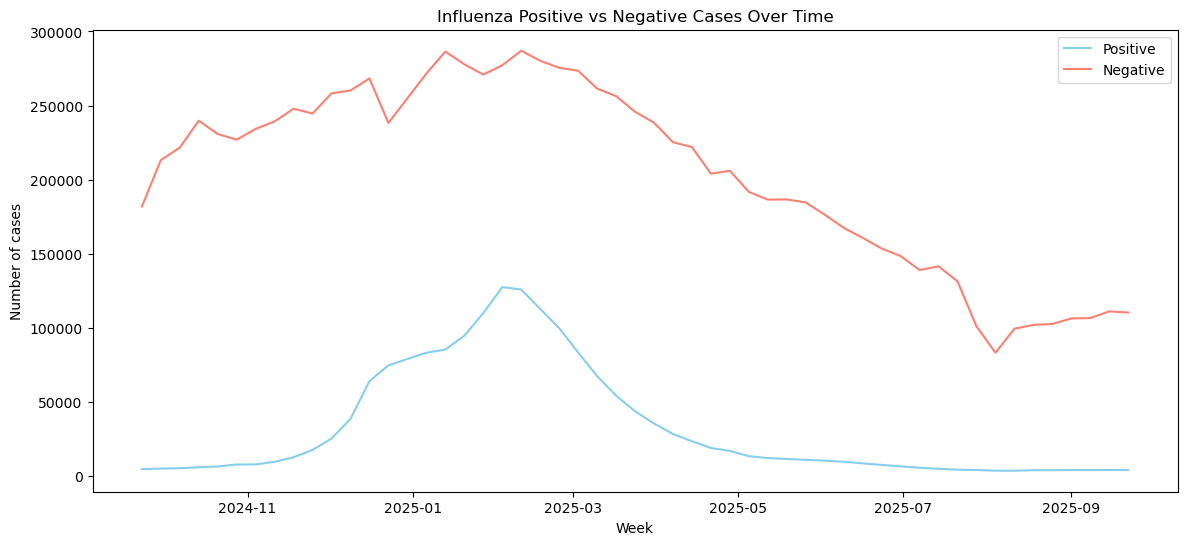

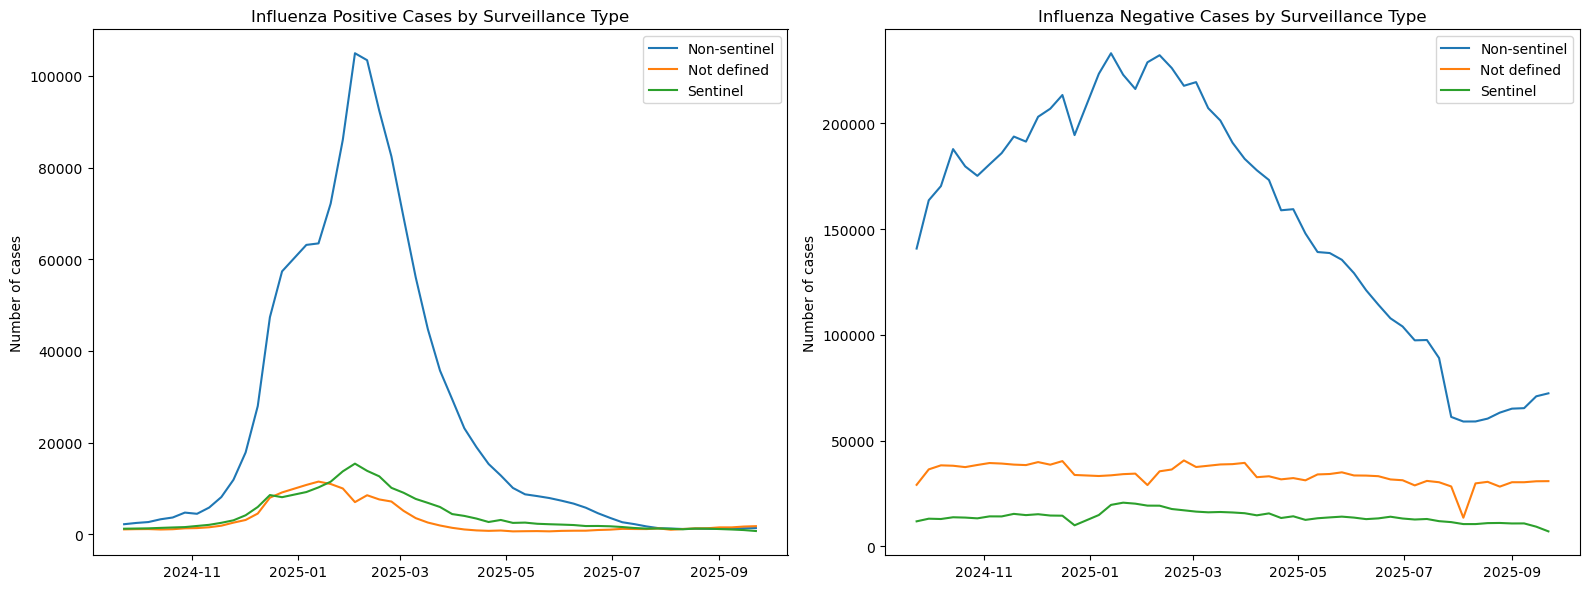

In [43]:
# Convert year-week to datetime for plotting
df_clean["Year-week (ISO 8601 calendar)"] = pd.to_datetime(
    df_clean["Year-week (ISO 8601 calendar)"] + "-1", format="%Y-%W-%w"
)

# Aggregate by week
weekly_data = df_clean.groupby("Year-week (ISO 8601 calendar)")[
    ["Influenza positive", "Influenza negative"]
].sum().reset_index()

# Plot positive & negative cases over time
plt.figure(figsize=(14,6))
plt.plot(weekly_data["Year-week (ISO 8601 calendar)"], weekly_data["Influenza positive"], label="Positive", color="skyblue")
plt.plot(weekly_data["Year-week (ISO 8601 calendar)"], weekly_data["Influenza negative"], label="Negative", color="salmon")
plt.title("Influenza Positive vs Negative Cases Over Time")
plt.xlabel("Week")
plt.ylabel("Number of cases")
plt.legend()
plt.show()

# Group by surveillance site type + week
site_weekly = df_clean.groupby(
    ["Year-week (ISO 8601 calendar)", "Surveillance site type"]
)[["Influenza positive", "Influenza negative"]].sum().reset_index()

# Plot by surveillance site type
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

for site_type in site_weekly["Surveillance site type"].unique():
    subset = site_weekly[site_weekly["Surveillance site type"] == site_type]
    axes[0].plot(subset["Year-week (ISO 8601 calendar)"], subset["Influenza positive"], label=site_type)
    axes[1].plot(subset["Year-week (ISO 8601 calendar)"], subset["Influenza negative"], label=site_type)

axes[0].set_title("Influenza Positive Cases by Surveillance Type")
axes[0].set_ylabel("Number of cases")
axes[0].legend()

axes[1].set_title("Influenza Negative Cases by Surveillance Type")
axes[1].set_ylabel("Number of cases")
axes[1].legend()

plt.tight_layout()
plt.show()


# Preprocessing step

In [44]:
# ===============================================
# 1. DATA PREPARATION AND SPLITTING
# ===============================================

# Make a copy to work with
df_model = df_clean.copy()

# Create positivity rate (Influenza positive / Specimen tested)
df_model["Positivity_rate"] = np.where(
    df_model["Specimen tested"] > 0,
    df_model["Influenza positive"] / df_model["Specimen tested"],
    0
)

# Drop any rows with zero specimens tested to avoid distortion
df_model = df_model[df_model["Specimen tested"] > 0]

# Define features and target
# For now, let's target "Positivity_rate" (continuous variable)
# You can later binarize it (e.g., high vs low positivity) for classification tasks.
X = df_model[[
    "Country area or territory",
    "Surveillance site type",
    "Specimen tested",
    "Influenza negative"
]]
y = df_model["Positivity_rate"]

# Split into train, validation, and test sets (70% / 15% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

# ===============================================
# 2. PREPROCESSING PIPELINE
# ===============================================

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
categorical_features = ["Country area or territory", "Surveillance site type"]
numerical_features = ["Specimen tested", "Influenza negative"]

# Preprocessing: impute missing, scale numericals, and one-hot encode categoricals
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing to training data (fit)
X_train_prepared = preprocessor.fit_transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
X_test_prepared = preprocessor.transform(X_test)

print("✅ Data preprocessing complete and ready for modeling.")


Train shape: (6749, 4)
Validation shape: (1446, 4)
Test shape: (1447, 4)
✅ Data preprocessing complete and ready for modeling.


In [55]:
# Check what values are in the week column
print(df_model.columns.tolist())


['Unnamed: 0', 'Country area or territory', 'Surveillance site type', 'Year-week (ISO 8601 calendar)', 'Week start date (ISO 8601 calendar)', 'Specimen tested', 'Influenza positive', 'Influenza negative', 'Positivity_rate']


# Baseline models

📈 Regression Model Performance:
MAE: 0.1080
MSE: 0.0241
R²: 0.3001


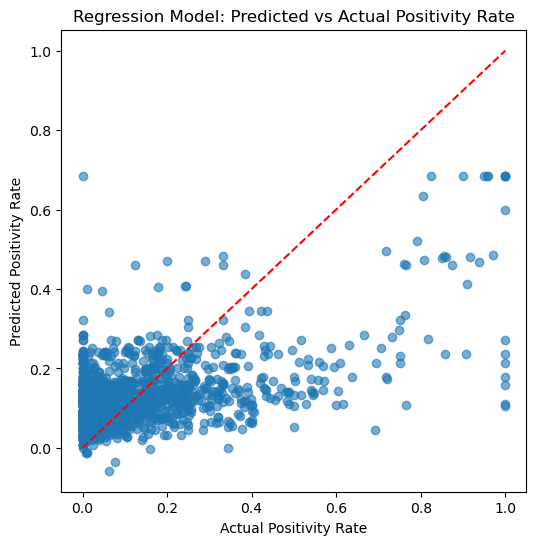


🧠 Classification Model Performance:
Accuracy: 0.6805
F1 Score: 0.6700
ROC-AUC: 0.7406


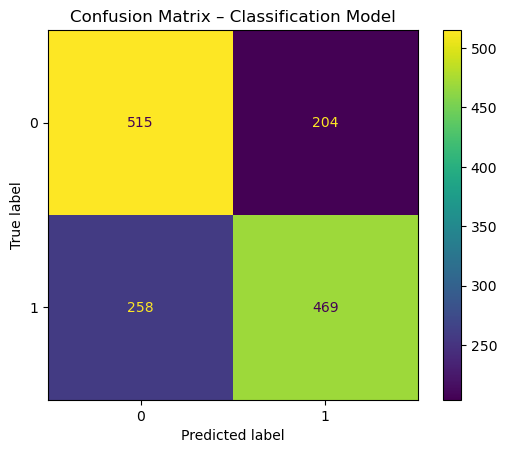

Forecast RMSE: 0.1445
Forecast R²: -0.2225


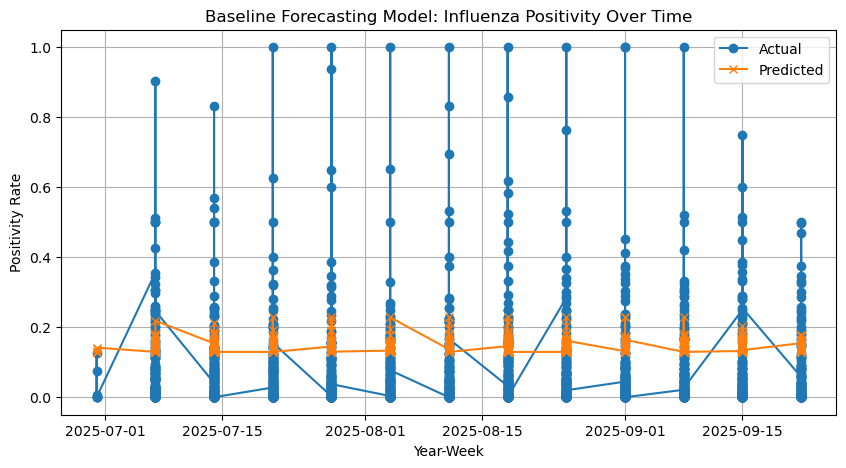

In [62]:
# =======================================================
# BASELINE MODELS: REGRESSION, CLASSIFICATION, FORECASTING
# =======================================================
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. REGRESSION MODEL
# -----------------------------------------

# Baseline regression: Linear Regression
reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
reg_model.fit(X_train, y_train)

y_pred_reg = reg_model.predict(X_val)

# Regression metrics
mae = mean_absolute_error(y_val, y_pred_reg)
mse = mean_squared_error(y_val, y_pred_reg)
r2 = r2_score(y_val, y_pred_reg)

print("📈 Regression Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_reg, alpha=0.6)
plt.plot([0, max(y_val)], [0, max(y_val)], 'r--')
plt.xlabel("Actual Positivity Rate")
plt.ylabel("Predicted Positivity Rate")
plt.title("Regression Model: Predicted vs Actual Positivity Rate")
plt.show()


# -----------------------------------------
# 2. CLASSIFICATION MODEL
# -----------------------------------------

# Create a binary classification target: high positivity (above median)
threshold = y_train.median()
y_train_class = (y_train > threshold).astype(int)
y_val_class = (y_val > threshold).astype(int)

clf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
clf_model.fit(X_train, y_train_class)
y_pred_class = clf_model.predict(X_val)
y_proba_class = clf_model.predict_proba(X_val)[:,1]

# Classification metrics
acc = accuracy_score(y_val_class, y_pred_class)
f1 = f1_score(y_val_class, y_pred_class)
roc_auc = roc_auc_score(y_val_class, y_proba_class)

print("\n🧠 Classification Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

ConfusionMatrixDisplay.from_predictions(y_val_class, y_pred_class)
plt.title("Confusion Matrix – Classification Model")
plt.show()


# -----------------------------------------
# 3. FORECASTING MODEL (Simplified Baseline)
# -----------------------------------------

# Update column references based on actual names
week_col = "Year-week (ISO 8601 calendar)"
pos_col = "Influenza positive"   
neg_col = "Influenza negative"   

df_forecast = df_model.copy()
df_forecast = df_forecast.rename(columns={week_col: "Year_week"})
df_forecast = df_forecast.sort_values("Year_week")

# Drop rows missing target variables
df_forecast = df_forecast.dropna(subset=[pos_col, neg_col])

# Create positivity rate
df_forecast["Positivity_rate"] = (
    df_forecast[pos_col] /
    (df_forecast[pos_col] + df_forecast[neg_col])
)

# Create a simple lag feature for forecasting
df_forecast["Lag_1"] = df_forecast["Positivity_rate"].shift(1)
df_forecast = df_forecast.dropna(subset=["Lag_1"])

# Define features and target
X_time = df_forecast[["Lag_1"]]
y_time = df_forecast["Positivity_rate"]

# Split train/validation
from sklearn.model_selection import train_test_split
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_time, y_time, test_size=0.2, shuffle=False
)

# Train and evaluate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

forecast_model = LinearRegression()
forecast_model.fit(X_train_t, y_train_t)
y_pred_t = forecast_model.predict(X_val_t)

rmse_t = mean_squared_error(y_val_t, y_pred_t) ** 0.5
r2_t = r2_score(y_val_t, y_pred_t)

print(f"Forecast RMSE: {rmse_t:.4f}")
print(f"Forecast R²: {r2_t:.4f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(df_forecast["Year_week"].iloc[-len(y_val_t):], y_val_t, label="Actual", marker="o")
plt.plot(df_forecast["Year_week"].iloc[-len(y_val_t):], y_pred_t, label="Predicted", marker="x")
plt.title("Baseline Forecasting Model: Influenza Positivity Over Time")
plt.xlabel("Year-Week")
plt.ylabel("Positivity Rate")
plt.legend()
plt.grid(True)
plt.show()



# Hyperparameter Tunning

### Classification Model (Random Forest Classifier)

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Initialize model
rf_clf = RandomForestClassifier(random_state=42)

# Grid Search
grid_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best cross-validated F1 score:", grid_rf.best_score_)

# Evaluate on validation set
y_pred_best = grid_rf.best_estimator_.predict(X_val)
print(classification_report(y_val, y_pred_best))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Rando

ValueError: 
All the 1080 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 359, in fit
    X, y = validate_data(
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Brazil'

--------------------------------------------------------------------------------
864 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 359, in fit
    X, y = validate_data(
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'France'


[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_sam

### Regression Model (Random Forest Regressor)

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Preprocessor: one-hot encode categorical columns, pass through numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Define model and pipeline
rf_reg = RandomForestRegressor(random_state=42)
model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_reg)
])

# Parameter grid (same as before)
param_grid_reg = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Grid search
grid_reg = GridSearchCV(
    estimator=model_reg,
    param_grid=param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_reg.fit(X_train, y_train)

print("✅ Best parameters:", grid_reg.best_params_)
print("📈 Best cross-validated R²:", grid_reg.best_score_)

# Evaluate on validation set
y_pred_best_reg = grid_reg.best_estimator_.predict(X_val)
import numpy as np
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_best_reg)))
print("Validation R²:", r2_score(y_val, y_pred_best_reg))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from 

✅ Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
📈 Best cross-validated R²: 0.9505944382883689
Validation RMSE: 0.02943462684540504
Validation R²: 0.974787523297294


### Forecasting Model (Random Forest)

In [70]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# --- Define key columns ---
target_col = "Positivity_rate"
week_col = "Year_week"

# Sort data chronologically
df_forecast = df_forecast.sort_values(week_col)

# Define features (everything except week and target)
feature_cols = [col for col in df_forecast.columns if col not in [week_col, target_col]]
X = df_forecast[feature_cols]
y = df_forecast[target_col]

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns
num_cols = X.select_dtypes(exclude=["object", "category"]).columns

# --- Preprocessing pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# --- Random Forest Regressor with Preprocessing ---
rf_forecast = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# --- Hyperparameter grid for tuning ---
param_grid_forecast = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [None, 5, 10, 20],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4]
}

# --- TimeSeries cross-validation ---
tscv = TimeSeriesSplit(n_splits=5)

# --- GridSearchCV setup ---
grid_forecast = GridSearchCV(
    estimator=rf_forecast,
    param_grid=param_grid_forecast,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

# --- Fit the model ---
grid_forecast.fit(X, y)

# --- Evaluate ---
print("✅ Best parameters:", grid_forecast.best_params_)
print("📈 Best cross-validated R²:", grid_forecast.best_score_)

# --- Validation split (last 20%) ---
split_idx = int(len(df_forecast) * 0.8)
X_train_t, X_val_t = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_t, y_val_t = y.iloc[:split_idx], y.iloc[split_idx:]

best_forecast_model = grid_forecast.best_estimator_
best_forecast_model.fit(X_train_t, y_train_t)

y_pred_t = best_forecast_model.predict(X_val_t)

rmse_t = np.sqrt(mean_squared_error(y_val_t, y_pred_t))
r2_t = r2_score(y_val_t, y_pred_t)

print(f"Validation RMSE: {rmse_t:.4f}")
print(f"Validation R²: {r2_t:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from

✅ Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
📈 Best cross-validated R²: 0.9581918524681494
Validation RMSE: 0.0060
Validation R²: 0.9979


#### Outbreak forecasting

In [71]:
# Create lag features for the model
def add_lag_features(df, target_col, lags=[1, 2, 3]):
    df = df.copy()
    for lag in lags:
        df[f"{target_col}_lag_{lag}"] = df[target_col].shift(lag)
    return df.dropna()

df_forecast_lagged = add_lag_features(df_forecast, target_col="Positivity_rate", lags=[1, 2, 3])


In [72]:
# Separate features and target again
feature_cols = [col for col in df_forecast_lagged.columns if col not in ["Year_week", "Positivity_rate"]]
X_all = df_forecast_lagged[feature_cols]
y_all = df_forecast_lagged["Positivity_rate"]

# Refit the best model on all available data
best_forecast_model.fit(X_all, y_all)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [73]:
from datetime import timedelta

# Define how many weeks to predict ahead
future_weeks = 8

# Get the last known week
last_week = df_forecast_lagged["Year_week"].max()

# Generate next weeks
future_dates = [last_week + pd.Timedelta(weeks=i) for i in range(1, future_weeks + 1)]

# Create placeholder DataFrame for future weeks
future_df = pd.DataFrame({"Year_week": future_dates})


In [74]:
future_predictions = []

# Copy last known row as starting point
last_row = df_forecast_lagged.iloc[-1:].copy()

for i, date in enumerate(future_dates):
    # Prepare feature input (excluding target)
    X_input = last_row[feature_cols]
    
    # Predict next week
    next_pred = best_forecast_model.predict(X_input)[0]
    
    # Store prediction
    future_predictions.append({"Year_week": date, "Predicted_Positivity_rate": next_pred})
    
    # Update lag features for next iteration
    for lag in [3, 2, 1]:
        if lag > 1:
            last_row[f"Positivity_rate_lag_{lag}"] = last_row[f"Positivity_rate_lag_{lag - 1}"]
    last_row["Positivity_rate_lag_1"] = next_pred  # shift in the new prediction


/var/folders/hr/0slpcpqd0zb50mphtylzzd2r0000gn/T/ipykernel_9354/1403548231.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


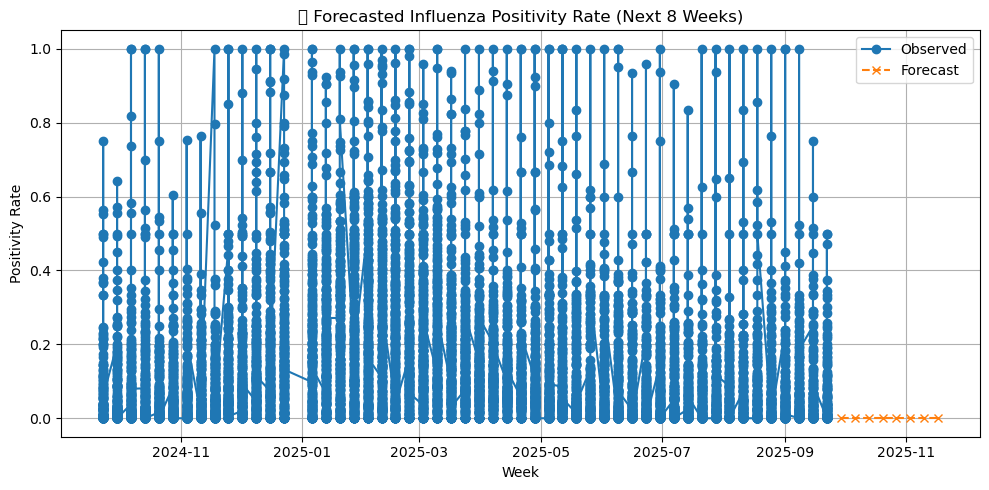

[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   8.3s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   4.1s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   8.1s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   1.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   4.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_es

In [75]:
# Combine historical + forecasted data
future_df = pd.DataFrame(future_predictions)
forecast_results = pd.concat([
    df_forecast_lagged[["Year_week", "Positivity_rate"]].rename(columns={"Positivity_rate": "Observed_Positivity_rate"}),
    future_df
])

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(forecast_results["Year_week"], forecast_results["Observed_Positivity_rate"], label="Observed", marker="o")
plt.plot(future_df["Year_week"], future_df["Predicted_Positivity_rate"], label="Forecast", linestyle="--", marker="x")
plt.title("📈 Forecasted Influenza Positivity Rate (Next 8 Weeks)")
plt.xlabel("Week")
plt.ylabel("Positivity Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Classification Model

/var/folders/hr/0slpcpqd0zb50mphtylzzd2r0000gn/T/ipykernel_9354/2548407381.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_classification["Week"] = pd.to_datetime(df_classification["Year-week (ISO 8601 calendar)"].astype(str) + "-1", errors="coerce").dt.isocalendar().week
/var/folders/hr/0slpcpqd0zb50mphtylzzd2r0000gn/T/ipykernel_9354/2548407381.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_classification["Year"] = pd.to_datetime(df_classification["Year-week (ISO 8601 calendar)"].astype(str) + "-1", errors="coerce").dt.isocalendar().year
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeCla

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/ie_deeplearning/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Decis

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9599032146560663
Precision: 0.9267697314890154
Recall: 0.9776824034334763
F1 Score: 0.9515455304928989
ROC AUC: 0.9627995350500714


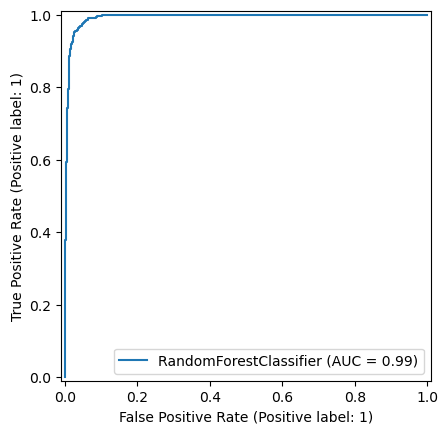

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; t

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# --- Step 1: Create the outbreak label ---
df_classification["Outbreak"] = (df_classification["Positivity_rate"] > 0.10).astype(int)

# --- Step 2: Extract week/year from ISO date ---
df_classification["Week"] = pd.to_datetime(df_classification["Year-week (ISO 8601 calendar)"].astype(str) + "-1", errors="coerce").dt.isocalendar().week
df_classification["Year"] = pd.to_datetime(df_classification["Year-week (ISO 8601 calendar)"].astype(str) + "-1", errors="coerce").dt.isocalendar().year

# --- Step 3: Drop target and original date column ---
X = df_classification.drop(columns=["Positivity_rate", "Outbreak", "Year-week (ISO 8601 calendar)"])
y = df_classification["Outbreak"]

# --- Step 4: One-hot encode categorical variables (e.g., Country, WHO Region) ---
X = pd.get_dummies(X, drop_first=True)

# --- Step 5: Train/test split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)

# --- Step 6: Random Forest Classifier with Grid Search ---
rf_class = RandomForestClassifier(random_state=42)

param_grid_class = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid_class = GridSearchCV(
    rf_class,
    param_grid_class,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_class.fit(X_train, y_train)

# --- Step 7: Evaluate ---
y_pred = grid_class.best_estimator_.predict(X_val)

print("Best Parameters:", grid_class.best_params_)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_pred))

# --- Optional: visualize ROC curve ---
RocCurveDisplay.from_estimator(grid_class.best_estimator_, X_val, y_val)
